# package_LAB

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors

import package_DBR
import package_LAB


from importlib import reload
package_LAB = reload(package_LAB)

from package_LAB import Lead_Lag_RT, PID
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode

In [32]:
# Lead_Lag_RT

In [33]:
help(Lead_Lag_RT)

Help on function Lead_Lag_RT in module package_LAB:

Lead_Lag_RT(MV, Kp, T_lead, T_lag, Ts, PV, PVInit=0, method='EBD')
    Lead_Lag_RT(MV,Kp,T_lead,T_lag,Ts,PV,PVInit=0,method='EBD')
        The function "Lead_Lag_RT" needs to be included in a "for or while loop".

        :MV: input vector
        :Kp: process gain
        :T_lead: lead time constant [s]
        :T_lag: lag time constant [s]
        :Ts: sampling period [s]
        :PV: output vector
        :PVInit: (optional: default value is 0)
        :method: discretisation method (optional: default value is 'EBD')
            EBD: Euler Backward difference
            EFD: Euler Forward difference
            TRAP: Trapezoïdal method

        The function appends a value to the output vector "PV".
        The appended value is obtained from a recurrent equation that depends on the discretisation method.



(0.0, 100.0)

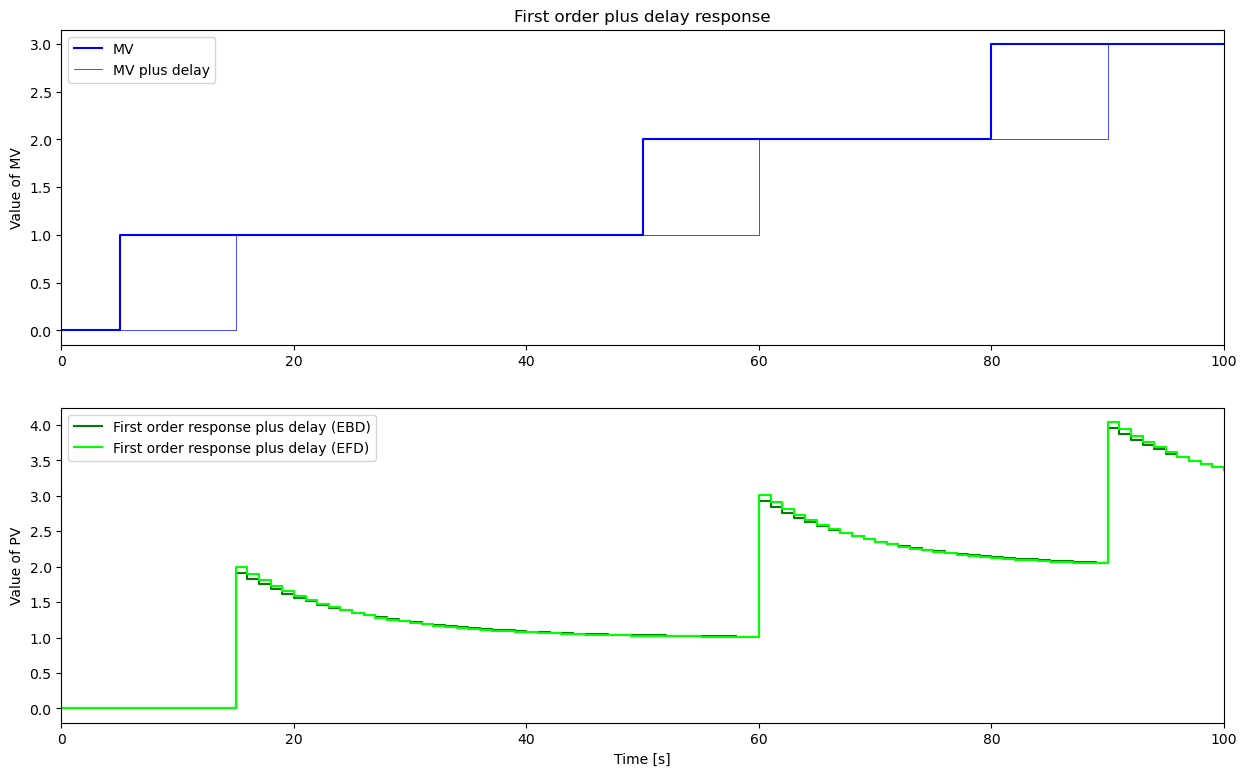

In [34]:
TSim = 100
Ts = 1
N = int(TSim/Ts) + 1

# Path for MV
MVPath = {0: 0, 5: 1, 50: 2, 80: 3, TSim: 3}

t = []
MV = []
MVDelay = []
PV_EBD = []
PV_EFD = []
PV_TRAP = []

# Parameters
Kp = 1
T_lead = 20
T_lag = 10
theta = 10

for i in range(0,N):
    t.append(i*Ts)
    SelectPath_RT(MVPath,t,MV)
    Delay_RT(MV,theta,Ts,MVDelay)
    Lead_Lag_RT(MVDelay,Kp,T_lead,T_lag,Ts,PV_EBD)
    Lead_Lag_RT(MVDelay,Kp,T_lead,T_lag,Ts,PV_EFD,0,'EFD')
    #Lead_Lag_RT(MVDelay,Kp,T_lead,T_lag,Ts,PV_TRAP,0,'TRAP')
    
plt.figure(figsize = (15,9))

plt.subplot(2,1,1)
plt.step(t,MV,'b-',label='MV',where='post')
plt.step(t,MVDelay,'b-',linewidth=0.5,label='MV plus delay',where='post')
plt.ylabel('Value of MV')
plt.title('First order plus delay response')
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(2,1,2)
plt.step(t,PV_EBD,'g-',label='First order response plus delay (EBD)',where='post')
plt.step(t,PV_EFD,'lime',label='First order response plus delay (EFD)',where='post')
#plt.step(t,PV_TRAP,'springgreen',label='First order response plus delay (TRAP)',where='post')
plt.ylabel('Value of PV')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, TSim])    

In [35]:
# PID Calculate

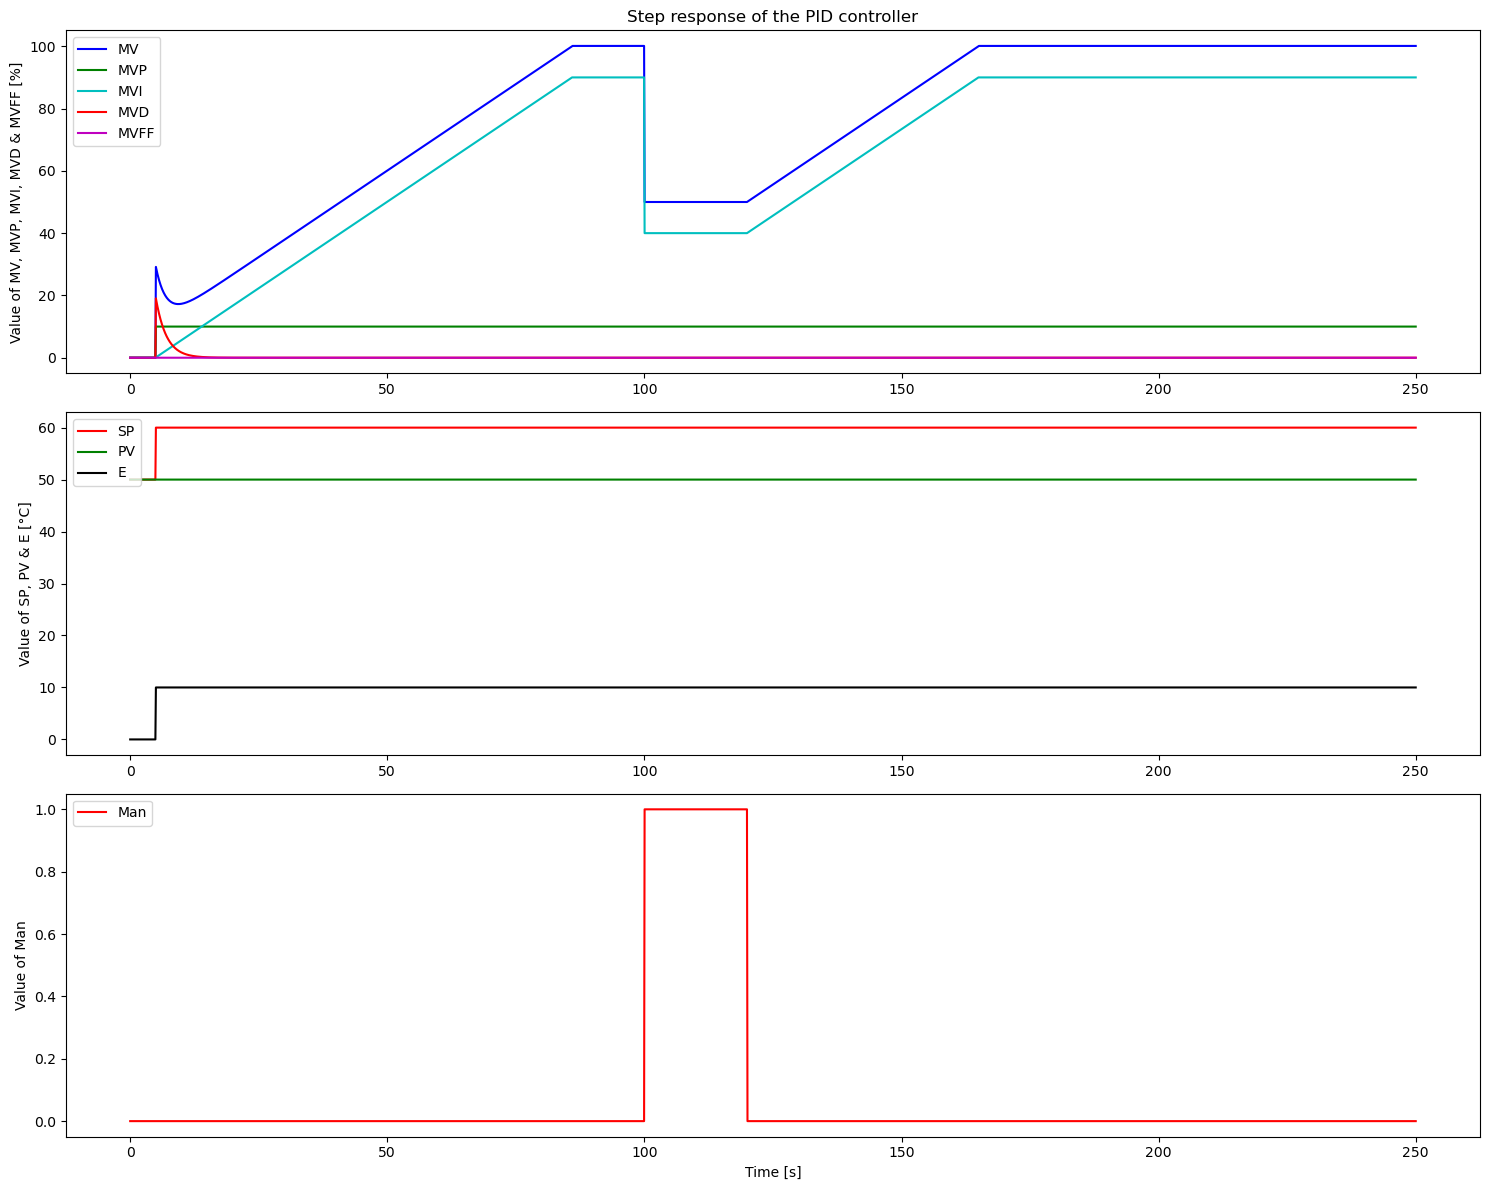

In [36]:
# Simulation parameters
TSim = 250        # Total simulation time
T_s = 0.1         # Sampling time
N = int(TSim / T_s)  # Number of samples

# PID parameters
K_C = 1
T_I = 9
T_D = 4
T_FD = 2

# Define SP (Setpoint) as seen in the screenshot
SP = np.zeros(N)
SP[:int(5 / T_s)] = 50      # SP = 50 from 0 to 50s
SP[int(5 / T_s):] = 60      # SP = 60 from 50s onwards

# Define initial PV (Process Variable) to start at 50 and change over time
PV = np.ones(N) * 50         # Start with PV = 50

# Manual (MAN) mode as per your example
MAN = np.zeros(N)
MAN[int(100 / T_s):int(120 / T_s)] = 1  # Manual mode enabled from 100s to 120s

# Initialize lists for PID components
MV = [0]                      # Manipulated Variable
MVP = [0]                     # Proportional Component
MVI = [0]                     # Integral Component
MVD = [0]                     # Derivative Component
MVFF = [0]                    # Feed-Forward Component
E = [SP[0] - PV[0]]           # Error term initialized with the first SP and PV
MVmax = 100
MVmin = 0
MANvalbase = 50
AUvalbase = 100


# PID control function and process simulation
for i in range(1, N):
    MVmax = MANvalbase
    # Calculate error
    
    E.append(SP[i] - PV[i-1])
    
    # Proportional term
    
    MVP.append(K_C * E[-1])
    
    # Integral term
    if(MAN[i] == 1):
        MVI.append(MANvalbase - MVP[-1])
        MVmax = MANvalbase
    #if(MVFF[i] != 0):
        
    else:
        MVI.append(MVI[-1] + (K_C * T_s / T_I) * E[-1])
        MVmax = AUvalbase
      
    # Derivative term
    MVD.append((T_FD / (T_FD + T_s)) * MVD[-1] + (K_C * T_D / (T_FD + T_s)) * (E[-1] - E[-2]))

    # Feed-forward term (assuming zero here; adjust as needed)
    MVFF = np.zeros(N)
    #MVFF[:int(200 / T_s)] = 0      # SP = 50 from 0 to 50s
    #MVFF[int(200 / T_s):] = 15      # SP = 60 from 50s onwards
    
    # Total output
    
    MV.append(MVP[-1] + MVI[-1] + MVD[-1] + MVFF[-1])
      
    #saturation
    if((MVP[-1] + MVI[-1]) > MVmax):
        MVI[-1] = MVmax - MVP[-1]
        
    if((MVP[-1] + MVI[-1]) < MVmin):
        MVI[-1] = MVmin - MVP[-1]   
    PV = np.zeros(N)
    PV[:int(250 / T_s)] = 50      # SP = 50 from 0 to 50s
       

# Time array for plotting
t = np.linspace(0, TSim, N)

# Plotting
plt.figure(figsize=(15, 12))

# Plot MV and its components
plt.subplot(3, 1, 1)
plt.plot(t, MV, 'b-', label='MV')
plt.plot(t, MVP, 'g-', label='MVP')
plt.plot(t, MVI, 'c-', label='MVI')
plt.plot(t, MVD, 'r-', label='MVD')
plt.plot(t, MVFF, 'm-', label='MVFF')
plt.ylabel('Value of MV, MVP, MVI, MVD & MVFF [%]')
plt.legend(loc='upper left')
plt.title('Step response of the PID controller')

# Plot SP, PV, and Error
plt.subplot(3, 1, 2)
plt.plot(t, SP, 'r-', label='SP')
plt.plot(t, PV, 'g-', label='PV')
plt.plot(t, E, 'k-', label='E')
plt.ylabel('Value of SP, PV & E [°C]')
plt.legend(loc='upper left')

# Plot Manual (MAN) mode
plt.subplot(3, 1, 3)
plt.plot(t, MAN, 'r-', label='Man')
plt.ylabel('Value of Man')
plt.xlabel('Time [s]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [37]:
help(RST_RT)

NameError: name 'RST_RT' is not defined